In [1]:
from pathlib import Path

from centrex_tlf import states, hamiltonian, couplings, utils, transitions

import matplotlib.pyplot as plt
import numpy as np
import networkx as nx
import papermill as pm
import pandas as pd


In [2]:
plt.rcParams.update({"font.size": 15})

In [3]:
ground_approx = states.generate_coupled_states_X(
    states.QuantumSelector(J=np.arange(6), electronic=states.ElectronicState.X)
)
excited_approx = states.generate_coupled_states_B(
    states.QuantumSelector(J=np.arange(1, 3), electronic=states.ElectronicState.B)
)


In [4]:
reduced_hamiltonian = hamiltonian.generate_total_reduced_hamiltonian(
    ground_approx, excited_approx, Jmax_B=5
)


In [5]:
C_arrays = couplings.collapse_matrices(
    reduced_hamiltonian.QN,
    reduced_hamiltonian.X_states,
    reduced_hamiltonian.B_states,
    hamiltonian.Γ,
)
br_arrays = C_arrays**2 / hamiltonian.Γ

In [6]:
coupling_fields = []
for pol in [couplings.polarization_σm, couplings.polarization_σp]:
    coupling = couplings.generate_coupling_matrix(
        reduced_hamiltonian.QN,
        reduced_hamiltonian.X_states,
        reduced_hamiltonian.B_states,
        pol_vec=pol.vector,
        reduced=False,
        normalize_pol=True,
    )
    coupling[np.abs(coupling) < 1e-3] = 0.0
    coupling_fields.append(coupling)


In [7]:
largest_states = [
    qn.transform_to_parity_basis().largest for qn in reduced_hamiltonian.QN
]


In [8]:
graph = nx.MultiDiGraph()
graph.add_nodes_from(largest_states)

idcs, idx_ground, idx_excited = np.nonzero(br_arrays)
graph.add_edges_from(
    [
        (
            largest_states[ide],
            largest_states[idg],
            {"coupling": br_arrays[idc, idg, ide].real, "type": "decay"},
        )
        for idc, idg, ide in zip(idcs, idx_ground, idx_excited)
    ],
)

for idc, coupling_field in enumerate(coupling_fields):
    if idc == 0:
        pol = "σm"
    else:
        pol = "σp"
    idx_ground, idx_excited = np.nonzero(np.triu(coupling_field))
    graph.add_edges_from(
        [
            (
                largest_states[idg],
                largest_states[ide],
                {
                    "coupling": coupling_field[idg, ide],
                    "type": "transition",
                    "polarization": pol,
                },
            )
            for idg, ide in zip(idx_ground, idx_excited)
        ],
    )


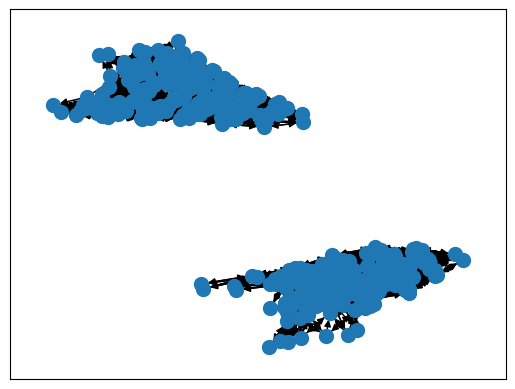

In [9]:
fig, ax = plt.subplots()

nx.draw_networkx(graph, ax=ax, node_size=100, with_labels=False)

In [10]:
from typing import Sequence


def make_node_groups(
    nodes: Sequence[states.CoupledBasisState], group_by: Sequence[str]
) -> dict[tuple, list[states.CoupledBasisState]]:
    groups: dict[tuple, list[states.CoupledBasisState]] = {}
    for node in nodes:
        values = tuple(getattr(node, key) for key in group_by)
        if groups.get(values) is None:
            groups[values] = [node]
        else:
            groups[values].append(node)
    return groups


In [11]:
ground_states = [
    qn.transform_to_parity_basis().largest for qn in reduced_hamiltonian.X_states
]
excited_states = [
    qn.transform_to_parity_basis().largest for qn in reduced_hamiltonian.B_states
]

# subdivide into J, F1, F combinations
excited_state_groups = make_node_groups(excited_states, ("J", "F1", "F", "P"))

# subdivide into J groups
ground_state_groups = make_node_groups(ground_states, ("J"))


In [12]:
import itertools
from dataclasses import dataclass


@dataclass
class CyclingScheme:
    Jg: tuple
    Je: tuple
    compensated: float
    compensated_total: float
    n_excited: int
    n_ground: int
    ratio: float


def check_cycling_schemes(
    ground_states, excited_states, graph: nx.MultiDiGraph, cutoff: float = 0.5
):
    results = []
    for (Jg, ground), (Je, excited) in itertools.product(ground_states, excited_states):
        to_check_gnd = list(
            set(
                [
                    item
                    for sublist in [
                        list(list(zip(*graph.out_edges(exc)))[1]) for exc in excited
                    ]
                    for item in sublist
                ]
            )
        )

        compensated = {}
        total = {}
        for exc in excited:
            for g in to_check_gnd:
                if total.get(g) is None:
                    total[g] = 0.0
                if g in ground:
                    if graph.has_edge(exc, g):
                        total[g] += (
                            graph.get_edge_data(exc, g)[0]["coupling"]
                            if graph.get_edge_data(exc, g)[0]["coupling"]
                            else 0.0
                        )
                        if graph.has_edge(g, exc):
                            if compensated.get(g) is None:
                                compensated[g] = 0.0
                            compensated[g] += graph.get_edge_data(exc, g)[0]["coupling"]

        compensated_total = dict([(key, total[key]) for key in compensated.keys()])

        comp = np.sum(list(compensated.values())) / len(excited)
        comp_tot = np.sum(list(compensated_total.values())) / len(excited)

        if comp_tot > cutoff:
            results.append(
                CyclingScheme(
                    Jg,
                    Je,
                    comp,
                    comp_tot,
                    len(excited),
                    len(compensated_total),
                    len(excited) / len(compensated_total),
                )
            )
    return results


In [50]:
excited_states_2 = [
    ((c[0][0], c[1][0]), c[0][1] + c[1][1])
    for c in itertools.combinations(excited_state_groups.items(), r=2)
]

# make sure both are of the same parity
excited_states_2 = [
    c
    for c in excited_states_2
    if (len(set([qn.P for qn in c[1]])) == 1) and not np.any([qn.J > 4 for qn in c[1]])
]


In [51]:
results = check_cycling_schemes(
    ground_state_groups.items(), excited_states_2, graph, cutoff=0.95
)
results = sorted(results, key=lambda x: x.compensated_total, reverse=True)
results


[CyclingScheme(Jg=(np.int64(4),), Je=((np.int64(4), np.float64(4.5), np.float64(4.0), -1), (np.int64(4), np.float64(4.5), np.float64(5.0), -1)), compensated=np.float64(0.8719678138195418), compensated_total=np.float64(0.9999885609542389), n_excited=20, n_ground=36, ratio=0.5555555555555556),
 CyclingScheme(Jg=(np.int64(1),), Je=((np.int64(1), np.float64(0.5), np.float64(0.0), 1), (np.int64(1), np.float64(0.5), np.float64(1.0), 1)), compensated=np.float64(0.7186519743658693), compensated_total=np.float64(0.9999050303356628), n_excited=4, n_ground=12, ratio=0.3333333333333333),
 CyclingScheme(Jg=(np.int64(4),), Je=((np.int64(4), np.float64(3.5), np.float64(3.0), -1), (np.int64(4), np.float64(4.5), np.float64(5.0), -1)), compensated=np.float64(0.7823793966394537), compensated_total=np.float64(0.9841701845743559), n_excited=18, n_ground=36, ratio=0.5),
 CyclingScheme(Jg=(np.int64(4),), Je=((np.int64(4), np.float64(3.5), np.float64(3.0), -1), (np.int64(4), np.float64(4.5), np.float64(4.0), 

In [52]:
# filter out transitions that jump more than J' = J +/- 2 or that use a Q(4) transition
results = [
    r for r in results if np.all(np.abs(np.array(r.Je)[:, 0] - np.array(r.Jg)) < 3)
]
results = [r for r in results if 4 not in np.array(r.Je)[:, 0]]
results

[CyclingScheme(Jg=(np.int64(1),), Je=((np.int64(1), np.float64(0.5), np.float64(0.0), 1), (np.int64(1), np.float64(0.5), np.float64(1.0), 1)), compensated=np.float64(0.7186519743658693), compensated_total=np.float64(0.9999050303356628), n_excited=4, n_ground=12, ratio=0.3333333333333333),
 CyclingScheme(Jg=(np.int64(3),), Je=((np.int64(3), np.float64(3.5), np.float64(3.0), 1), (np.int64(3), np.float64(3.5), np.float64(4.0), 1)), compensated=np.float64(0.904067722342823), compensated_total=np.float64(0.9682630086681815), n_excited=16, n_ground=28, ratio=0.5714285714285714),
 CyclingScheme(Jg=(np.int64(3),), Je=((np.int64(3), np.float64(2.5), np.float64(2.0), 1), (np.int64(3), np.float64(3.5), np.float64(4.0), 1)), compensated=np.float64(0.8927695836534507), compensated_total=np.float64(0.9526462068028593), n_excited=14, n_ground=28, ratio=0.5),
 CyclingScheme(Jg=(np.int64(3),), Je=((np.int64(3), np.float64(2.5), np.float64(2.0), 1), (np.int64(3), np.float64(3.5), np.float64(3.0), 1)), c

In [53]:
transition_params = [
    [
        [
            transitions.OpticalTransitionType(Je.item() - r.Jg[0].item()).name,
            r.Jg[0].item(),
            F1.item(),
            F.item(),
        ]
        for Je, F1, F, P in r.Je
    ]
    for r in results
]

transition_params = [
    params
    for params in transition_params
    if not np.any([t[0] == "O" or t[0] == "S" for t in params])
]

J_fills = [list(set(tuple([ti[1] for ti in t]))) for t in transition_params]

In [54]:
path = Path().cwd()

for J_fill, trans_param in list(zip(J_fills, transition_params)):
    # don't do S or O transitions
    if np.any([t[0] == "S" or t[0] == "O" for t in trans_param]):
        continue
    trans = [
        transitions.OpticalTransition(transitions.OpticalTransitionType[t], J, F1, F)
        for t, J, F1, F in trans_param
    ]
    fname = " __ ".join([t.name.replace("'", "").replace("/", "_") for t in trans])
    print(trans)
    pm.execute_notebook(
        path / "papermill_template_cma.ipynb",
        path / f"{fname}_cma.ipynb",
        parameters=dict(transition_params=trans_param, J_fill=J_fill),
    )

[OpticalTransition(Q(1) F1'=1/2 F'=0), OpticalTransition(Q(1) F1'=1/2 F'=1)]


Executing:   0%|          | 0/40 [00:00<?, ?cell/s]

[OpticalTransition(Q(3) F1'=7/2 F'=3), OpticalTransition(Q(3) F1'=7/2 F'=4)]


Executing:   0%|          | 0/40 [00:00<?, ?cell/s]

[OpticalTransition(Q(3) F1'=5/2 F'=2), OpticalTransition(Q(3) F1'=7/2 F'=4)]


Executing:   0%|          | 0/40 [00:00<?, ?cell/s]

[OpticalTransition(Q(3) F1'=5/2 F'=2), OpticalTransition(Q(3) F1'=7/2 F'=3)]


Executing:   0%|          | 0/40 [00:00<?, ?cell/s]

In [55]:
ground_states_2 = [
    ((c[0][0][0], c[1][0][0]), c[0][1] + c[1][1])
    for c in itertools.combinations(ground_state_groups.items(), r=2)
]

# make sure both are of the same parity
ground_states_2 = [c for c in ground_states_2 if (len(set([qn.P for qn in c[1]])) == 1)]


In [56]:
results = check_cycling_schemes(
    ground_states_2, excited_state_groups.items(), graph, cutoff=0.95
)
results = [r for r in results if np.diff(r.Jg) <= 2]
results = [r for r in results if not np.any([ji >= 4 for ji in r.Jg])]
results = sorted(results, key=lambda x: x.compensated_total, reverse=True)
results


[CyclingScheme(Jg=(np.int64(0), np.int64(2)), Je=(np.int64(1), np.float64(1.5), np.float64(1.0), -1), compensated=np.float64(0.6666583695022623), compensated_total=np.float64(0.9999999999999999), n_excited=3, n_ground=17, ratio=0.17647058823529413),
 CyclingScheme(Jg=(np.int64(1), np.int64(3)), Je=(np.int64(1), np.float64(1.5), np.float64(1.0), 1), compensated=np.float64(0.8159190290042679), compensated_total=np.float64(0.9999999999852679), n_excited=3, n_ground=17, ratio=0.17647058823529413),
 CyclingScheme(Jg=(np.int64(1), np.int64(3)), Je=(np.int64(2), np.float64(1.5), np.float64(2.0), 1), compensated=np.float64(0.7438628972833258), compensated_total=np.float64(0.9999999998195477), n_excited=5, n_ground=30, ratio=0.16666666666666666),
 CyclingScheme(Jg=(np.int64(0), np.int64(2)), Je=(np.int64(1), np.float64(0.5), np.float64(1.0), -1), compensated=np.float64(0.6665506702159212), compensated_total=np.float64(0.9999999997316701), n_excited=3, n_ground=17, ratio=0.17647058823529413),
 C

In [57]:
transition_params = [
    [
        [
            transitions.OpticalTransitionType(r.Je[0] - Jg).name,
            Jg.item(),
            *[ri.item() for ri in r.Je[1:-1]],
        ]
        for Jg in r.Jg
    ]
    for r in results
]

transition_params = [
    params
    for params in transition_params
    if not np.any([t[0] == "O" or t[0] == "S" for t in params])
]

J_fills = [list(set(tuple([ti[1] for ti in t]))) for t in transition_params]

In [58]:
transition_params

[[['R', 0, 1.5, 1.0], ['P', 2, 1.5, 1.0]],
 [['R', 1, 1.5, 2.0], ['P', 3, 1.5, 2.0]],
 [['R', 0, 0.5, 1.0], ['P', 2, 0.5, 1.0]],
 [['R', 1, 1.5, 1.0], ['P', 3, 1.5, 1.0]],
 [['R', 1, 2.5, 2.0], ['P', 3, 2.5, 2.0]],
 [['R', 1, 2.5, 3.0], ['P', 3, 2.5, 3.0]],
 [['R', 0, 1.5, 2.0], ['P', 2, 1.5, 2.0]]]

In [59]:
path = Path().cwd()

for J_fill, trans_param in zip(J_fills, transition_params):
    # don't do S or O transitions
    if np.any([t[0] == "S" or t[0] == "O" for t in trans_param]):
        continue
    trans = [
        transitions.OpticalTransition(transitions.OpticalTransitionType[t], J, F1, F)
        for t, J, F1, F in trans_param
    ]
    fname = " __ ".join([t.name.replace("'", "").replace("/", "_") for t in trans])
    print(trans)
    pm.execute_notebook(
        path / "papermill_template_cma.ipynb",
        path / f"{fname}_cma.ipynb",
        parameters=dict(transition_params=trans_param, J_fill=J_fill),
    )

[OpticalTransition(R(0) F1'=3/2 F'=1), OpticalTransition(P(2) F1'=3/2 F'=1)]


Executing:   0%|          | 0/40 [00:00<?, ?cell/s]

[OpticalTransition(R(1) F1'=3/2 F'=2), OpticalTransition(P(3) F1'=3/2 F'=2)]


Executing:   0%|          | 0/40 [00:00<?, ?cell/s]

[OpticalTransition(R(0) F1'=1/2 F'=1), OpticalTransition(P(2) F1'=1/2 F'=1)]


Executing:   0%|          | 0/40 [00:00<?, ?cell/s]

[OpticalTransition(R(1) F1'=3/2 F'=1), OpticalTransition(P(3) F1'=3/2 F'=1)]


Executing:   0%|          | 0/40 [00:00<?, ?cell/s]

[OpticalTransition(R(1) F1'=5/2 F'=2), OpticalTransition(P(3) F1'=5/2 F'=2)]


Executing:   0%|          | 0/40 [00:00<?, ?cell/s]

[OpticalTransition(R(1) F1'=5/2 F'=3), OpticalTransition(P(3) F1'=5/2 F'=3)]


Executing:   0%|          | 0/40 [00:00<?, ?cell/s]

[OpticalTransition(R(0) F1'=3/2 F'=2), OpticalTransition(P(2) F1'=3/2 F'=2)]


Executing:   0%|          | 0/40 [00:00<?, ?cell/s]

In [62]:
df = pd.read_csv(path / "results_cma.csv")

In [63]:
df.sort_values("photons", ascending=False)

,transition 0,J_ground 0,F1 0,F 0,transition 1,J_ground 1,F1 1,F 1,Ωl0,Ωl1,phase1,ω0,ω1,φ1,ton0,ton1,toff0,toff1,photons
0,Q,1,0.5,0.0,Q,1,0.5,1.0,0.601019,0.183711,2.467261,0.917438,0.446866,0.761829,6.426480,4.220031,0.895376,1.675444,86.525466
9,R,1,2.5,3.0,P,3,2.5,3.0,1.275605,0.733092,1.628022,0.621277,1.062967,0.281367,3.375082,14.083002,17.378678,0.374944,86.074143
10,R,0,1.5,2.0,P,2,1.5,2.0,1.363842,0.557653,0.336029,0.560297,1.284437,1.452563,0.458114,9.925816,2.124758,7.469557,67.955868
5,R,1,1.5,2.0,P,3,1.5,2.0,0.394372,0.020975,0.015561,0.618070,1.236473,3.866707,2.703827,14.843572,1.354377,7.073174,64.644351
6,R,0,0.5,1.0,P,2,0.5,1.0,0.669821,0.005741,1.202520,0.482952,0.484019,0.524073,3.219867,6.649991,1.576878,1.072430,41.051907
8,R,1,2.5,2.0,P,3,2.5,2.0,0.245686,0.686727,0.916051,0.831797,0.405525,0.610569,13.170524,7.041429,4.134681,2.719803,28.781537
1,Q,3,3.5,3.0,Q,3,3.5,4.0,0.204249,1.914774,0.246833,1.416943,1.418039,4.792559,2.003987,4.945043,14.677324,1.832483,25.023483
2,Q,3,2.5,2.0,Q,3,3.5,4.0,0.008227,1.914207,2.305375,0.315986,1.285520,1.848407,14.944348,39.968035,35.172341,6.993206,23.697876
3,Q,3,2.5,2.0,Q,3,3.5,3.0,0.005712,0.090659,0.290332,0.128956,0.488368,3.112059,1.402608,8.819422,5.079563,0.810579,22.527181
4,R,0,1.5,1.0,P,2,1.5,1.0,0.232129,0.495551,0.567039,0.423800,0.854758,6.209230,16.526978,11.142166,1.735465,3.714892,12.951830


# Generate graphs best transitions

In [64]:
def generate_layout(ground_states, excited_states):
    Js = np.unique([gs.J for gs in ground_states])
    positions = []

    I_Tl = 1 / 2
    I_F = 1 / 2
    J_F1_F_combos = [
        (J, F1, F)
        for J in Js
        for F1 in np.arange(np.abs(J - I_F), J + I_F + 1)
        for F in np.arange(np.abs(F1 - I_Tl), F1 + I_Tl + 1)
    ]
    F1_F_mapping = dict([(key, val) for val, key in enumerate(J_F1_F_combos)])
    J_mapping = dict(
        [(J, idj * 2 * (J + 1)) for idj, J in enumerate(range(min(Js), max(Js) + 10))]
    )

    for ground_state in ground_states:
        positions.append(
            (
                ground_state,
                np.array(
                    [
                        ground_state.mF + J_mapping[ground_state.J],
                        F1_F_mapping[ground_state.J, ground_state.F1, ground_state.F],
                    ]
                ),
            )
        )

    Js = np.unique([es.J for es in excited_states])
    J_F1_F_combos = [
        (J, F1, F)
        for J in Js
        for F1 in np.arange(np.abs(J - I_F), J + I_F + 1)
        for F in np.arange(np.abs(F1 - I_Tl), F1 + I_Tl + 1)
    ]
    F1_F_mapping = dict([(key, val) for val, key in enumerate(J_F1_F_combos)])
    for excited_state in excited_states:
        positions.append(
            (
                excited_state,
                np.array(
                    [
                        excited_state.mF + J_mapping[excited_state.J],
                        F1_F_mapping[excited_state.J, excited_state.F1, excited_state.F]
                        + 7,
                    ]
                ),
            )
        )

    return dict(positions)

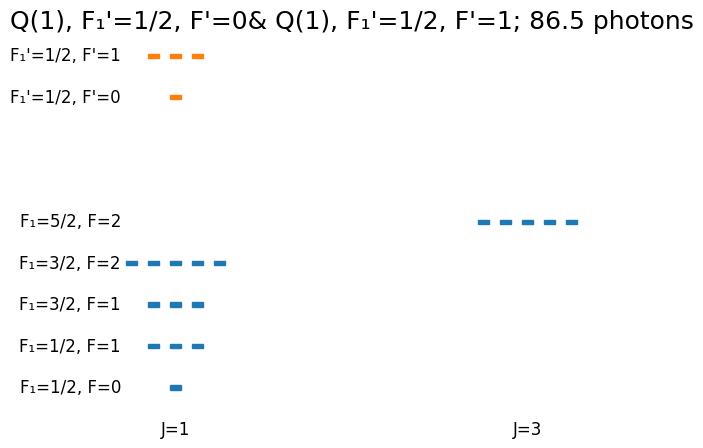

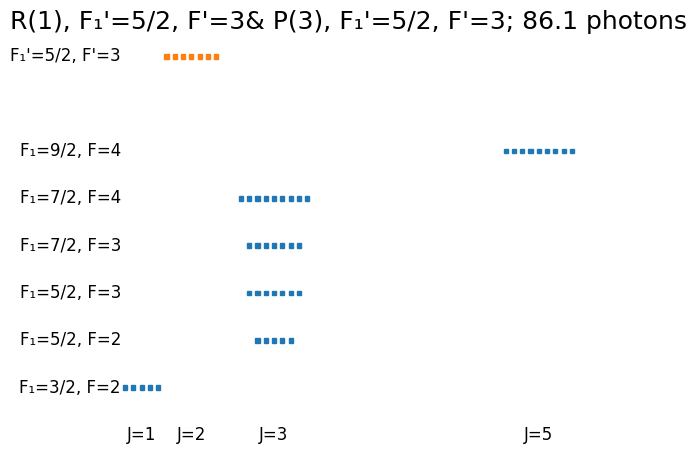

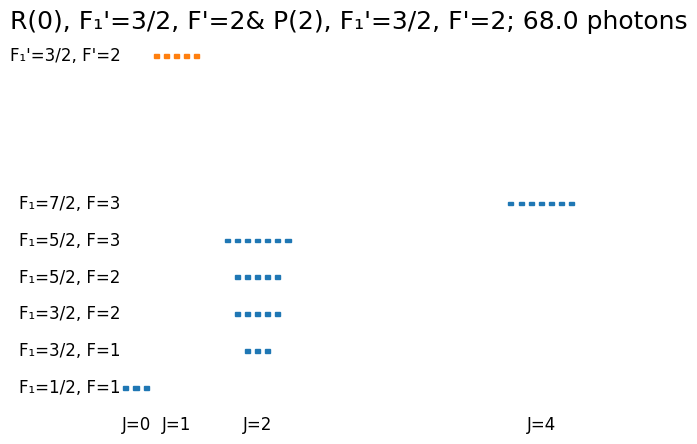

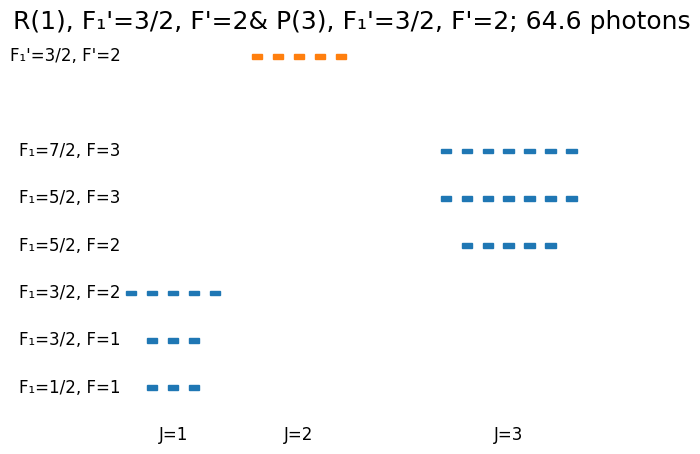

In [71]:
import fractions


for ind, row in df.sort_values("photons", ascending=False).iterrows():
    if row.photons < 50:
        continue
    Js = np.unique([row["J_ground 0"], row["J_ground 1"]])
    ground_states = states.generate_coupled_states_X(
        states.QuantumSelector(J=Js, electronic=states.ElectronicState.X)
    )
    if len(Js) > 1:
        excited_states = states.generate_coupled_states_B(
            [
                states.CoupledBasisState(
                    J=Js[0] + transitions.OpticalTransitionType[row["transition 0"]],
                    F1=row["F1 0"],
                    F=row["F 0"],
                    mF=mFi,
                    I1=1 / 2,
                    I2=1 / 2,
                    Omega=1,
                    P=states.utils.parity_X(Js[0]) * -1,
                    electronic_state=states.ElectronicState.B,
                    basis=states.Basis.CoupledP,
                )
                for mFi in range(-int(row["F 0"]), +int(row["F 0"]) + 1)
            ]
        )
    if len(Js) == 1:
        excited_states = states.generate_coupled_states_B(
            [
                states.CoupledBasisState(
                    J=Js[0] + transitions.OpticalTransitionType[row["transition 0"]],
                    F1=row["F1 0"],
                    F=row["F 0"],
                    mF=mFi,
                    I1=1 / 2,
                    I2=1 / 2,
                    Omega=1,
                    P=states.utils.parity_X(Js[0]) * -1,
                    electronic_state=states.ElectronicState.B,
                    basis=states.Basis.CoupledP,
                )
                for mFi in range(-int(row["F 0"]), +int(row["F 0"]) + 1)
            ]
        )
        excited_states.extend(
            [
                states.CoupledBasisState(
                    J=Js[0] + transitions.OpticalTransitionType[row["transition 1"]],
                    F1=row["F1 1"],
                    F=row["F 1"],
                    mF=mFi,
                    I1=1 / 2,
                    I2=1 / 2,
                    Omega=1,
                    P=states.utils.parity_X(Js[0]) * -1,
                    electronic_state=states.ElectronicState.B,
                    basis=states.Basis.CoupledP,
                )
                for mFi in range(-int(row["F 1"]), +int(row["F 1"]) + 1)
            ]
        )

    ground_states = [graph.neighbors(node) for node in excited_states]
    ground_states = list(set([item for sublist in ground_states for item in sublist]))

    node_width = 0.5
    node_height = 0.1

    graph_trans = graph.subgraph(ground_states + excited_states).copy()

    nodes_to_remove = [
        node for node in graph_trans.nodes() if graph_trans.degree(node) == 0
    ]
    graph_trans.remove_nodes_from(nodes_to_remove)

    layout = generate_layout(ground_states, excited_states)

    size = [4 * size for _, size in graph_trans.degree(graph_trans.nodes())]
    color_map = [
        "C0" if s.electronic_state == states.ElectronicState.X else "C1"
        for s in graph_trans.nodes()
    ]
    fig, ax = plt.subplots()
    # nx.draw_networkx_nodes(graph_trans, pos=layout, ax=ax, node_color=color_map)
    for node, color in zip(graph_trans.nodes(), color_map):
        x, y = layout[node]
        ax.plot(x, y, ".", color=color, ms=0.01)
        ax.add_patch(
            plt.Rectangle(
                (x - node_width / 2, y - node_height / 2),
                node_width,
                node_height,
                color=color,
            )
        )

    labels = np.unique(
        [
            (key.J, key.F1, key.F, key.electronic_state.value, layout[key][1])
            for key in graph_trans.nodes()
        ],
        axis=0,
    )
    for label in labels:
        x = min([val[0] for _, val in layout.items()]) - 1 / 2
        y = label[4]
        if label[3] == 1:
            s = f"F₁={fractions.Fraction(label[1])}, F={label[2]:.0f}"
        else:
            s = f"F₁'={fractions.Fraction(label[1])}, F'={label[2]:.0f}"
        ax.text(x, y, s, fontsize=12, va="center", ha="right")

    Jincluded = np.unique([label[0] for label in labels]).astype(int)
    J_mapping = dict(
        [
            (J, idj * 2 * (J + 1))
            for idj, J in enumerate(range(Jincluded[0], Jincluded[-1] + 1))
        ]
    )
    for J in Jincluded:
        ax.text(
            J_mapping[J],
            labels[:, -1].min() - 1,
            f"J={J:.0f}",
            fontsize=12,
            va="center",
            ha="center",
        )

    ax.axis("off")
    title = f"{row["transition 0"]}({row["J_ground 0"]}), F₁'={fractions.Fraction(row["F1 0"])}, F'={row["F 0"]:.0f}"
    title += f"& {row["transition 1"]}({row["J_ground 1"]}), F₁'={fractions.Fraction(row["F1 1"])}, F'={row["F 1"]:.0f}"
    title += f"; {row["photons"]:.1f} photons"
    ax.set_title(title)

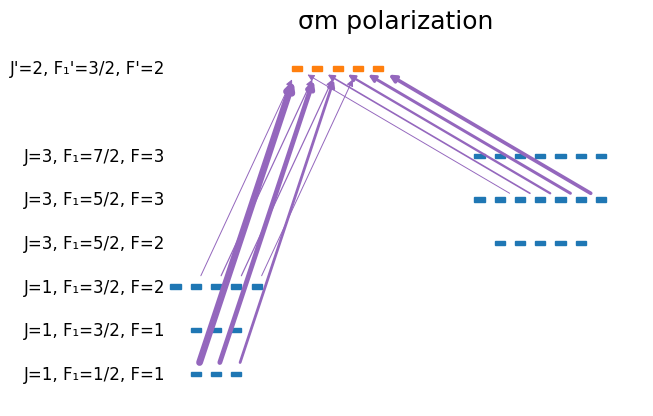

In [33]:
import fractions

pol = "σm"

node_width = 0.5
node_height = 0.1

graph_trans = graph.subgraph(ground_states + excited_states).copy()

nodes_to_remove = [
    node for node in graph_trans.nodes() if graph_trans.degree(node) == 0
]
graph_trans.remove_nodes_from(nodes_to_remove)

layout = generate_layout(ground_states, excited_states)

size = [4 * size for _, size in graph_trans.degree(graph_trans.nodes())]
color_map = [
    "C0" if s.electronic_state == states.ElectronicState.X else "C1"
    for s in graph_trans.nodes()
]
fig, ax = plt.subplots()
# nx.draw_networkx_nodes(graph_trans, pos=layout, ax=ax, node_color=color_map)
for node, color in zip(graph_trans.nodes(), color_map):
    x, y = layout[node]
    ax.add_patch(
        plt.Rectangle(
            (x - node_width / 2, y - node_height / 2),
            node_width,
            node_height,
            color=color,
        )
    )

edges_transition = [
    (u, v, attr)
    for u, v, attr in graph_trans.edges(data=True)
    if attr.get("polarization") == pol and np.abs(attr.get("coupling")) > 1e-1
]

edges_decay = [
    (u, v, attr)
    for u, v, attr in graph_trans.edges(data=True)
    if attr.get("type") == "decay"
    and np.abs(attr.get("coupling")) > 1e-2
    and u in [e for _, e, _ in edges_transition]
]

offset = 0  # Amount to shift in x direction
layout_offset = {node: (x + offset, y) for node, (x, y) in layout.items()}
# widths = [abs(attr.get("coupling")) for u, v, attr in graph_trans.edges(data=True)]
nx.draw_networkx_edges(
    graph_trans,
    pos=layout_offset,
    edgelist=[(u, v) for u, v, _ in edges_transition],
    width=[6 * abs(attr.get("coupling")) for _, _, attr in edges_transition],
    edge_color="C4",
)

# offset = 0.1  # Amount to shift in x direction
# layout_offset = {node: (x + offset, y) for node, (x, y) in layout.items()}
# nx.draw_networkx_edges(
#     graph_trans,
#     pos=layout_offset,
#     edgelist=[(u, v) for u, v, _ in edges_decay],
#     edge_color="k",
#     width=[12 * abs(attr.get("coupling")) for _, _, attr in edges_decay],
# )

labels = np.unique(
    [
        (key.J, key.F1, key.F, key.electronic_state.value, layout[key][1])
        for key in graph_trans.nodes()
    ],
    axis=0,
)

for label in labels:
    x = min([val[0] for _, val in layout.items()]) - 1 / 2
    y = label[4]
    if label[3] == 1:
        s = f"J={label[0]:.0f}, F₁={fractions.Fraction(label[1])}, F={label[2]:.0f}"
    else:
        s = f"J'={label[0]:.0f}, F₁'={fractions.Fraction(label[1])}, F'={label[2]:.0f}"
    ax.text(x, y, s, fontsize=12, va="center", ha="right")

ax.set_title(f"{pol} polarization")
ax.axis("off");
